# Figure 4
## Global Exposure Trends

Drop Day/Year labels on 4a.

``Done.``

Add back in vertical bars for 30-year running mean slopes to 4a

``Done.``

Take "Hatching indicates" text off of 4b. This will go in the caption.

``Done.``

Can we calculate the inflection point of hazard and exposure in 4b? It would be nice to be able to say quantitatively if inflection point is delayed in exposure relative to hazard and by how much.

``See the last code cell in this notebook.``

In [1]:
import xarray
from distributed import Client
import numpy as np
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask

f_background_color = "#ffffff"
ax_background_color = "#ffffff"
grid_line_color = "#e8e8e8"
grid_line_lw = 0.8
all_color = "Black"
xaer_color = "Purple"
xghg_color = "Green"

client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=20 threads=40, memory=0.91 TiB>

In [2]:
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")


pop_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/WorldPop/unconstrained/global_mosaic/1km/people_per_pixel/ppp_2020_1km_Aggregated.tif"
pop_ds_raw = xarray.open_dataset(pop_path)["band_data"].sel(band=1)

hw_mx_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMX_HW_METRICS.zarr"
hw_mx_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMX_HW_METRICS.zarr"
hw_mx_xghg_path = f"{HW_DIR}CESM1_LE_xghg_TREFHTMX_HW_METRICS.zarr"
OUTPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/MERRA2/HEAT_OUTPUTS/"
hw_mx_merra_path = f"{OUTPUT_DIR}MERRA2_T2MMIN_HW_METRICS.zarr"


hw_mx_all = xarray.open_zarr(hw_mx_all_path)
hw_mx_xaer = xarray.open_zarr(hw_mx_xaer_path)
hw_mx_xghg = xarray.open_zarr(hw_mx_xghg_path)
hw_mx_merra = xarray.open_zarr(hw_mx_merra_path)

d_lat = hw_mx_all.lat.values[1] - hw_mx_all.lat.values[0]
lat_groups = np.arange(hw_mx_all.lat.values[0] - 0.5*d_lat, hw_mx_all.lat.values[-1] + 0.6*d_lat, d_lat)
d_lon = hw_mx_all.lon.values[1] - hw_mx_all.lon.values[0]
lon_groups = np.arange(hw_mx_all.lon.values[0] - 0.5*d_lon, hw_mx_all.lon.values[-1] + 0.6*d_lon, d_lon)
pop_ds_raw = pop_ds_raw.assign_coords(x=(pop_ds_raw.x.values % 360)).sortby("x")
pop_ds_resampled = pop_ds_raw.groupby_bins("y", lat_groups, labels=hw_mx_all.lat.values).sum().groupby_bins("x", lon_groups, labels=hw_mx_all.lon.values).sum()
pop_ds = pop_ds_resampled.rename({"y_bins":"lat", "x_bins":"lon"})


hw_mx_all_exposure_ts = hw_mx_all.sel(percentile=0.9).weighted(pop_ds).mean(dim=["lat", "lon"]).compute()
hw_mx_xaer_exposure_ts = hw_mx_xaer.sel(percentile=0.9).weighted(pop_ds).mean(dim=["lat", "lon"]).compute()
hw_mx_xghg_exposure_ts = hw_mx_xghg.sel(percentile=0.9).weighted(pop_ds).mean(dim=["lat", "lon"]).compute()
hw_mx_merra_exposure_ts = hw_mx_merra.sel(percentile=0.9).weighted(pop_ds).mean(dim=["lat", "lon"]).compute()

hw_mx_all_ts = hw_mx_all.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mx_all.lat))).mean(dim=["lat", "lon"]).compute()
hw_mx_xaer_ts = hw_mx_xaer.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mx_xaer.lat))).mean(dim=["lat", "lon"]).compute()
hw_mx_xghg_ts = hw_mx_xghg.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mx_xghg.lat))).mean(dim=["lat", "lon"]).compute()
hw_mx_merra_ts = hw_mx_merra.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mx_merra.lat))).mean(dim=["lat", "lon"]).compute()

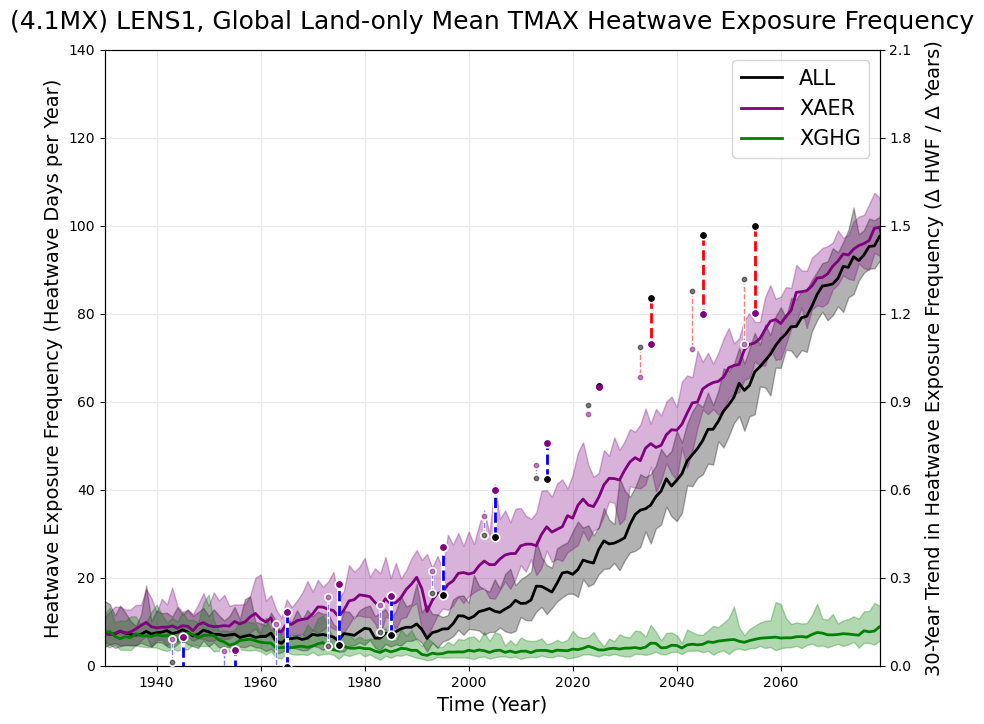

In [3]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

for i in np.arange(1940, 2080, 20):
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in np.arange(0, 140, 20):
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

hw_mx_all_exposure_ts["HWF"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=2, label="ALL")
hw_mx_xaer_exposure_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="XAER")
hw_mx_xghg_exposure_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="XGHG")

# lw = 1.5
# hw_mx_all_ts["HWF"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=lw, alpha=alpha, label="ALL")
# hw_mx_xaer_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=lw, alpha=alpha, label="XAER")
# hw_mx_xghg_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=lw, alpha=alpha, label="XGHG")


a = 0.3
ax1.fill_between(hw_mx_all_exposure_ts["HWF"].year.values, hw_mx_all_exposure_ts["HWF"].min(dim="member"), hw_mx_all_exposure_ts["HWF"].max("member"), alpha=a, color=all_color)
ax1.fill_between(hw_mx_xaer_exposure_ts["HWF"].year.values, hw_mx_xaer_exposure_ts["HWF"].min(dim="member"), hw_mx_xaer_exposure_ts["HWF"].max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mx_xghg_exposure_ts["HWF"].year.values, hw_mx_xghg_exposure_ts["HWF"].min(dim="member"), hw_mx_xghg_exposure_ts["HWF"].max("member"), alpha=a, color=xghg_color)

ax11 = ax1.twinx()

regression_centers = np.arange(1945, 2065, 10)
all_regressions = np.zeros((2, regression_centers.size))
xaer_regressions = np.zeros((2, regression_centers.size))

for index, center in enumerate(regression_centers):
    hw_mx_all_ts_slice = hw_mx_all_exposure_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")
    hw_mx_xaer_ts_slice = hw_mx_xaer_exposure_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")

    all_regressions[:, index] = np.polyfit(hw_mx_all_ts_slice.year.values, hw_mx_all_ts_slice.values, 1)
    xaer_regressions[:, index] = np.polyfit(hw_mx_xaer_ts_slice.year.values, hw_mx_xaer_ts_slice.values, 1)

for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=3, linestyle="-", color="White", zorder=0)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="--", color=color, zorder=5)
s = 40
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10)

s = 15
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15)

regression_centers = np.arange(1943, 2060, 10)
all_regressions = np.zeros((2, regression_centers.size))
xaer_regressions = np.zeros((2, regression_centers.size))

for index, center in enumerate(regression_centers):
    hw_mx_all_ts_slice = hw_mx_all_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")
    hw_mx_xaer_ts_slice = hw_mx_xaer_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")

    all_regressions[:, index] = np.polyfit(hw_mx_all_ts_slice.year.values, hw_mx_all_ts_slice.values, 1)
    xaer_regressions[:, index] = np.polyfit(hw_mx_xaer_ts_slice.year.values, hw_mx_xaer_ts_slice.values, 1)

alpha = 0.5
for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="-", color="White", zorder=0, alpha=1)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=1, linestyle="--", color=color, zorder=5, alpha=alpha)

s = 30
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10, alpha=1)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10, alpha=1)

s = 10
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15, alpha=alpha)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15, alpha=alpha)

ax11.set_yticks(np.arange(0, 2.2, 0.3))
ax11.set_ylim(0, 2.1)
ax11.set_ylabel("30-Year Trend in Heatwave Exposure Frequency (Δ HWF / Δ Years)", fontsize=14, labelpad=10)

ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(0, 140)
ax1.set_title("(4.1MX) LENS1, Global Land-only Mean TMAX Heatwave Exposure Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Heatwave Exposure Frequency (Heatwave Days per Year)", fontsize=14)

f.show()

Text(0, 0.5, 'Δ Heatwave Exposure Frequency (Δ Heatwave Days per Year)')

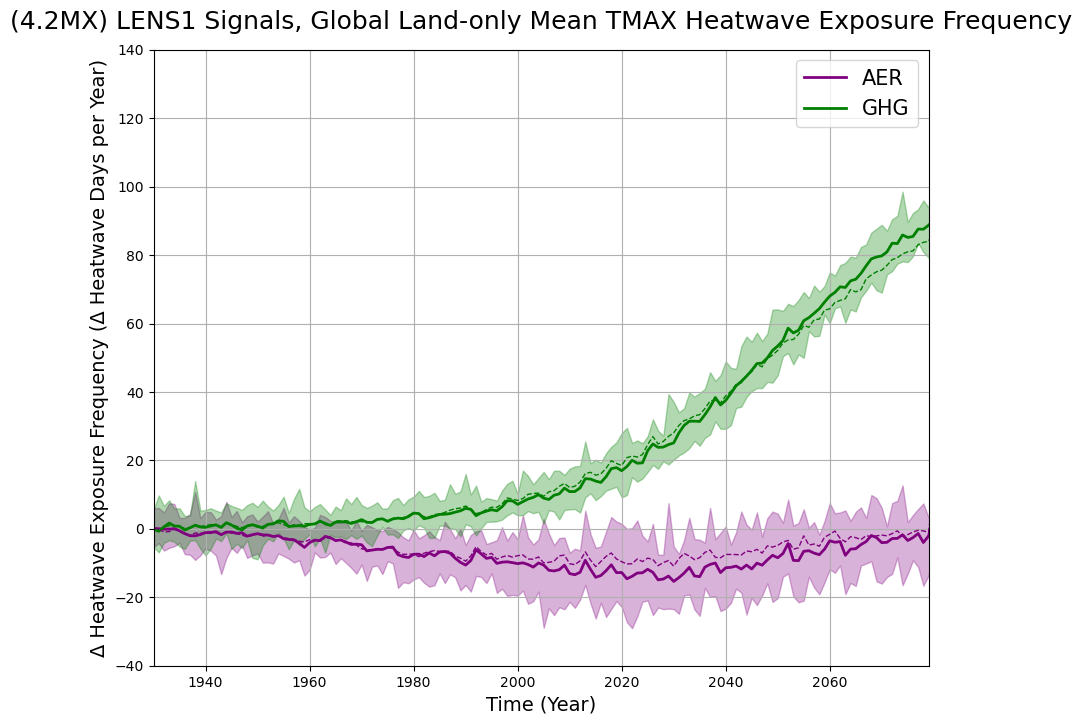

In [4]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

hw_mx_aer_exposure_ts = hw_mx_all_exposure_ts["HWF"] - hw_mx_xaer_exposure_ts["HWF"]
hw_mx_ghg_exposure_ts = hw_mx_all_exposure_ts["HWF"] - hw_mx_xghg_exposure_ts["HWF"]

hw_mx_aer_exposure_ts.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="AER")
hw_mx_ghg_exposure_ts.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="GHG")

hw_mx_aer_ts = hw_mx_all_ts["HWF"] - hw_mx_xaer_ts["HWF"]
hw_mx_ghg_ts = hw_mx_all_ts["HWF"] - hw_mx_xghg_ts["HWF"]

hw_mx_aer_ts.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=1, linestyle="--")
hw_mx_ghg_ts.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=1, linestyle="--")

a = 0.3
ax1.fill_between(hw_mx_aer_exposure_ts.year.values, hw_mx_aer_exposure_ts.min(dim="member"), hw_mx_aer_exposure_ts.max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mx_aer_exposure_ts.year.values, hw_mx_ghg_exposure_ts.min(dim="member"), hw_mx_ghg_exposure_ts.max("member"), alpha=a, color=xghg_color)


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(-40, 140)
ax1.set_title("(4.2MX) LENS1 Signals, Global Land-only Mean TMAX Heatwave Exposure Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ Heatwave Exposure Frequency (Δ Heatwave Days per Year)", fontsize=14)

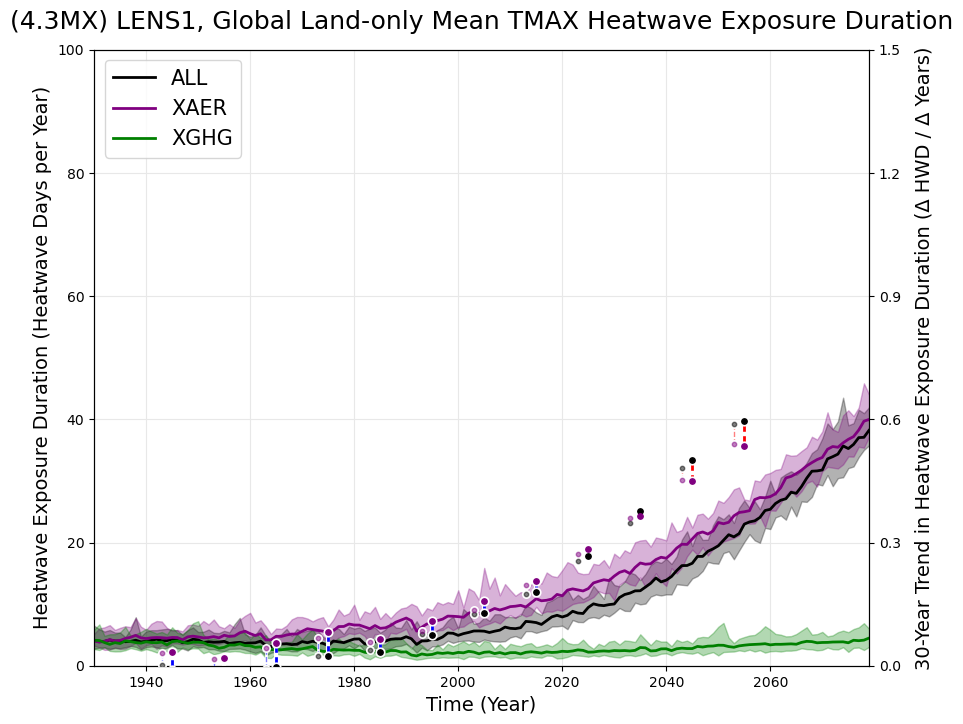

In [5]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

for i in np.arange(1940, 2080, 20):
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in np.arange(0, 140, 20):
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

hw_mx_all_exposure_ts["HWD"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=2, label="ALL")
hw_mx_xaer_exposure_ts["HWD"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="XAER")
hw_mx_xghg_exposure_ts["HWD"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="XGHG")

# lw = 1.5
# hw_mx_all_ts["HWD"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=lw, alpha=alpha, label="ALL")
# hw_mx_xaer_ts["HWD"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=lw, alpha=alpha, label="XAER")
# hw_mx_xghg_ts["HWD"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=lw, alpha=alpha, label="XGHG")


a = 0.3
ax1.fill_between(hw_mx_all_exposure_ts["HWD"].year.values, hw_mx_all_exposure_ts["HWD"].min(dim="member"), hw_mx_all_exposure_ts["HWD"].max("member"), alpha=a, color=all_color)
ax1.fill_between(hw_mx_xaer_exposure_ts["HWD"].year.values, hw_mx_xaer_exposure_ts["HWD"].min(dim="member"), hw_mx_xaer_exposure_ts["HWD"].max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mx_xghg_exposure_ts["HWD"].year.values, hw_mx_xghg_exposure_ts["HWD"].min(dim="member"), hw_mx_xghg_exposure_ts["HWD"].max("member"), alpha=a, color=xghg_color)

ax11 = ax1.twinx()

regression_centers = np.arange(1945, 2065, 10)
all_regressions = np.zeros((2, regression_centers.size))
xaer_regressions = np.zeros((2, regression_centers.size))

for index, center in enumerate(regression_centers):
    hw_mx_all_ts_slice = hw_mx_all_exposure_ts["HWD"].sel(year=slice(center-15, center+14)).mean(dim="member")
    hw_mx_xaer_ts_slice = hw_mx_xaer_exposure_ts["HWD"].sel(year=slice(center-15, center+14)).mean(dim="member")

    all_regressions[:, index] = np.polyfit(hw_mx_all_ts_slice.year.values, hw_mx_all_ts_slice.values, 1)
    xaer_regressions[:, index] = np.polyfit(hw_mx_xaer_ts_slice.year.values, hw_mx_xaer_ts_slice.values, 1)

for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=3, linestyle="-", color="White", zorder=0)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="--", color=color, zorder=5)
s = 40
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10)

s = 15
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15)

regression_centers = np.arange(1943, 2060, 10)
all_regressions = np.zeros((2, regression_centers.size))
xaer_regressions = np.zeros((2, regression_centers.size))

for index, center in enumerate(regression_centers):
    hw_mx_all_ts_slice = hw_mx_all_ts["HWD"].sel(year=slice(center-15, center+14)).mean(dim="member")
    hw_mx_xaer_ts_slice = hw_mx_xaer_ts["HWD"].sel(year=slice(center-15, center+14)).mean(dim="member")

    all_regressions[:, index] = np.polyfit(hw_mx_all_ts_slice.year.values, hw_mx_all_ts_slice.values, 1)
    xaer_regressions[:, index] = np.polyfit(hw_mx_xaer_ts_slice.year.values, hw_mx_xaer_ts_slice.values, 1)

alpha = 0.5
for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="-", color="White", zorder=0, alpha=1)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=1, linestyle="--", color=color, zorder=5, alpha=alpha)

s = 30
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10, alpha=1)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10, alpha=1)

s = 10
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15, alpha=alpha)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15, alpha=alpha)

ax11.set_yticks(np.arange(0, 1.6, 0.3))
ax11.set_ylim(0, 1.5)
ax11.set_ylabel("30-Year Trend in Heatwave Exposure Duration (Δ HWD / Δ Years)", fontsize=14, labelpad=10)

ax1.legend(fontsize=15, loc="upper left")
ax1.set_xlim(1930, 2079)
ax1.set_ylim(0, 100)
ax1.set_title("(4.3MX) LENS1, Global Land-only Mean TMAX Heatwave Exposure Duration", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Heatwave Exposure Duration (Heatwave Days per Year)", fontsize=14)

f.show()

Text(0, 0.5, 'Δ Heatwave Exposure Duration (Δ Heatwave Days per Year)')

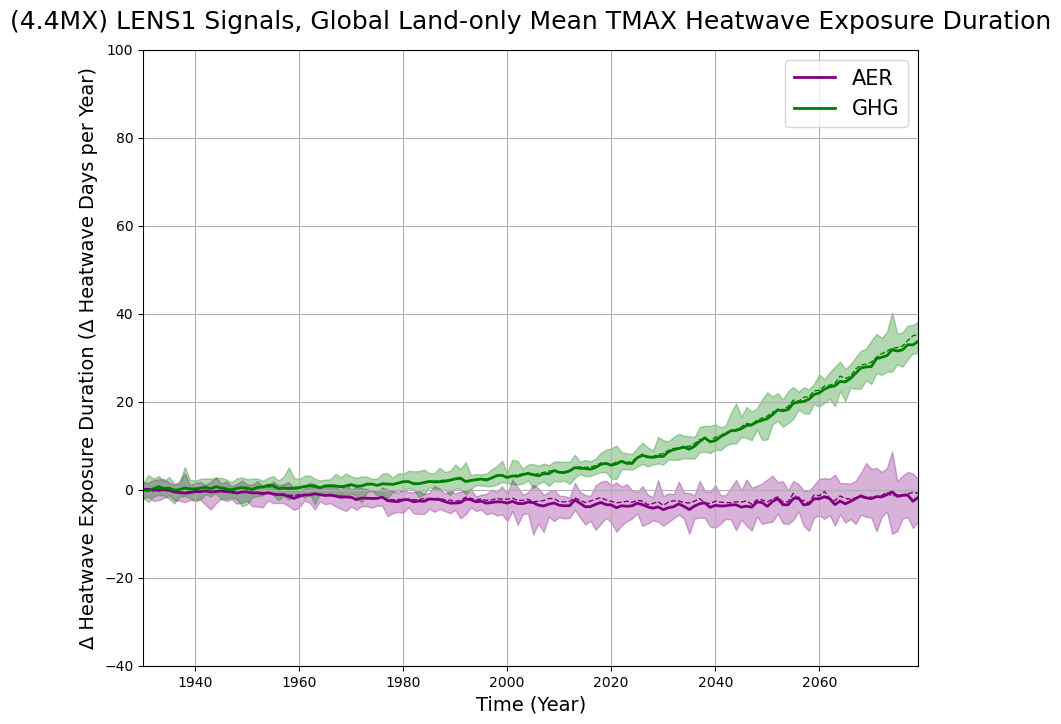

In [6]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

hw_mx_aer_exposure_ts = hw_mx_all_exposure_ts["HWD"] - hw_mx_xaer_exposure_ts["HWD"]
hw_mx_ghg_exposure_ts = hw_mx_all_exposure_ts["HWD"] - hw_mx_xghg_exposure_ts["HWD"]

hw_mx_aer_exposure_ts.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="AER")
hw_mx_ghg_exposure_ts.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="GHG")

hw_mx_aer_ts = hw_mx_all_ts["HWD"] - hw_mx_xaer_ts["HWD"]
hw_mx_ghg_ts = hw_mx_all_ts["HWD"] - hw_mx_xghg_ts["HWD"]

hw_mx_aer_ts.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=1, linestyle="--")
hw_mx_ghg_ts.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=1, linestyle="--")

a = 0.3
ax1.fill_between(hw_mx_aer_exposure_ts.year.values, hw_mx_aer_exposure_ts.min(dim="member"), hw_mx_aer_exposure_ts.max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mx_aer_exposure_ts.year.values, hw_mx_ghg_exposure_ts.min(dim="member"), hw_mx_ghg_exposure_ts.max("member"), alpha=a, color=xghg_color)


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(-40, 100)
ax1.set_title("(4.4MX) LENS1 Signals, Global Land-only Mean TMAX Heatwave Exposure Duration", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ Heatwave Exposure Duration (Δ Heatwave Days per Year)", fontsize=14)